## LETKF
- データ同化Aの講義資料をみる
- 8メンバーで走る

### アルゴリズム
$ \tilde{P^a} = [(N-1)I/\rho + dY^T R^{-1} dY]^{-1} $

$ T = \tilde{P^a} dY^T R^{-1}(y^o - \overline{dY^f}) + [(N-1) \tilde{P^a}]^{1/2} $

$ X^a = x^f + dX^f T$

### localiztion
- 各点で分けて解析を行う．
- その際に

### Question
- 

## LETKFのdebug
TODO
- [x] LETKF実装方針の検討
    - [x] EnSRF(ETKF)を拡張: 
        - serialize ETKFを拡張
        - $y^o$の各変数で両隣を合わせた3変数の同化を行う．
    - [ ] 新たにLETKFを実装
- [ ] その他はちゃんと動いているか確認
- [ ] localizationの方法の確立
    - [x] K-loc : serialize KF($y^o$の40成分を一つずつ同化)のKalman gainに$ \rho_i $をかける．

- [ ] リファクタリング
  - [ ] 計算量の評価
  - [ ] 各成分の同化で不要な成分の計算を省く
  - [ ] 一般の観測次元で実装

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# モジュールの読み込み
import sys
sys.path.append('./module')
from utils import make_lorenz96, rk4, error_series_kf, plot_error_KF, estimate_error_with_params
from localization import plot_gaspari_cohn
from kalman_filters import LocalEnsembleTransformKalmanFilter as LETKF

In [2]:
# Lorenz96の設定
J = 40
F = 8
lorenz = make_lorenz96(F)

# 同化step
# 時間発展は0.01ごとに行う
dt = 0.05

# モデルの遷移関数(非線形)
# 0.01ずつ時間発展させる
# dtは同化step
def M(x, dt):
    for i in range(int(dt/0.01)):
        x = rk4(0, x, 0.01, lorenz)
    return x

# 単位行列
I = np.identity(J)

# 観測
H = I

# モデル誤差共分散, 最初は完全モデルを仮定
Q = np.zeros((J, J))

# 観測誤差共分散, 後で定数倍の変化をさせる.
R = I

# 観測値と真値
y = np.load('data/obs_atr.npy')
true = np.load('data/true_atr.npy')

# KFの初期値
np.random.seed(0)
x_0 = true[np.random.randint(len(true)-1)]
P_0 = 25*I

## Gaspari Cohn
- $ 2c $で$0$になる．
- 対応するgassianのスケールは$L = c(0.3)^{1/2}$(標準偏差$ L = c(0.3)^2 $のgaussianに対応．)

### gaspari cohn vs gaussian
パラメータの対応関係．以下の対応がある．

$ G_c(x, c) \leftrightarrow \exp(- \frac{x^2}{2L^2}) $

ただし，$ L = c(0.3)^{1/2} $

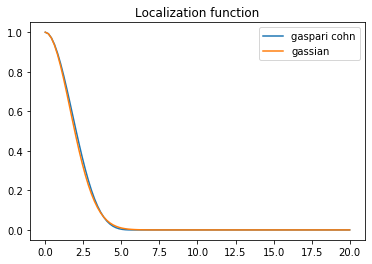

In [44]:
c = c
L = c*(0.3)**(1/2)
plot_gaspari_cohn(c)
x_arr = np.linspace(0, 20, 100)
y_func = [np.exp(-x**2/(2*L**2)) for x in x_arr]
plt.plot(x_arr, y_func, label='gassian')
plt.legend()

## parameter推定
推定20min程度 -> 結果: 21min46s

In [41]:
# %%time
# m=8
# spin_up = 150
# duration = 150

# num_alpha = 11
# num_c = 10
# params_alpha = np.linspace(1.0, 1.5, num=num_alpha)
# params_c = np.arange(num_c) + 1
# errors = np.zeros((num_alpha, num_c))

# for i in range(num_alpha):
#     alpha = params_alpha[i]
#     for j in range(num_c):
#         c = params_c[j]
#         letkf = LETKF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, c=c)
#         letkf.forward_estimation()
#         error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
#         errors[i,j] = error
#         print('complete: alpha: {}, c: {}, error: {}'.format(alpha, c, error))
#     print('=======================')
# df = pd.DataFrame(errors, index=params_alpha, columns=params_c)
# df.to_csv('data/letkf/letkf_alpha_c_rough.csv')

Text(42.0, 0.5, 'alpha')

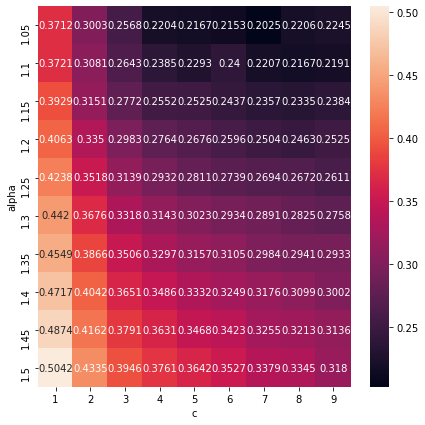

In [25]:
df = pd.read_csv('data/letkf/letkf_alpha_c_rough.csv', index_col=0, header=0)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(df.iloc[1:, :9], annot=True, fmt='.4g')
ax.set_xlabel('c')
ax.set_ylabel('alpha')

### 細かく調整
実行時間: 1h 40min 28s

In [40]:
# %%time
# m=8
# spin_up = 200
# duration = len(true) - spin_up

# num_alpha = 11
# num_c = 11
# params_alpha = np.linspace(1.05-0.05, 1.05+0.05, num=num_alpha)
# params_c = np.arange(num_c)*(2/5) + 6
# errors = np.zeros((num_alpha, num_c))

# for i in range(num_alpha):
#     alpha = params_alpha[i]
#     for j in range(num_c):
#         c = params_c[j]
#         letkf = LETKF(M, H, Q, R, y[:spin_up+duration], x_0, P_0, m=m, alpha=alpha, c=c)
#         letkf.forward_estimation()
#         error = error_series_kf(true, letkf.x, time_index=np.arange(duration)+spin_up).mean()
#         errors[i,j] = error
#         print('complete: alpha: {}, c: {}, error: {}'.format(alpha, c, error))
#     print('=======================')
# df = pd.DataFrame(errors, index=params_alpha, columns=params_c)
# df.to_csv('data/letkf/letkf_alpha_c_detail.csv')

Text(42.0, 0.5, 'alpha')

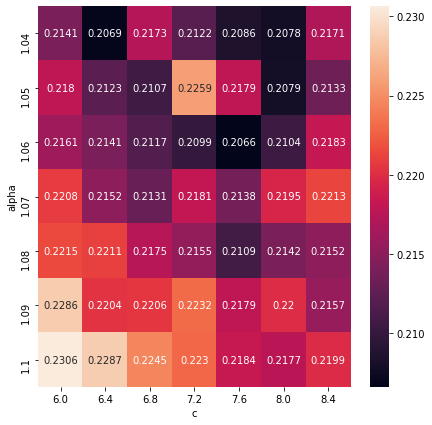

In [24]:
df = pd.read_csv('data/letkf/letkf_alpha_c_detail.csv', index_col=0, header=0)
fig, ax = plt.subplots(figsize=(7,7))
sns.heatmap(df.iloc[4:, :7], annot=True, fmt='.4g')
ax.set_xlabel('c')
ax.set_ylabel('alpha')

In [40]:
%%time
m = 8
alpha = 1.06
sigma = 4.5
c = sigma*(0.3**(-1/2))
letkf = LETKF(M, H, Q, R, y[:], x_0, P_0, m=m, alpha=alpha, c=c, localization='', addaptive=False)
letkf.forward_estimation()
# plot_error_KF(true, y, [letkf.x, letkf.x_f], trPs=[letkf.trP], legends=['x_a', 'x_f'])
# estimate_error_with_params(true, [letkf.x], [m], 'm')
# plot_gaspari_cohn(c)
# print(c)

CPU times: user 6min 47s, sys: 2.63 s, total: 6min 49s
Wall time: 51.4 s


In [41]:
np.save('data/letkf/letkf_optimal.npy', [letkf.x, letkf.trP])

## 失敗の記録
- ETKFを拡張してserial LETKFを作った時の結果
- TODO: 以下を再現
    - 安定までが遅い．
    - 安定後に途中で誤差が大きくなる

In [ ]:
#=========================
# serial LETKF
#=========================
"""
実装:
    概要:
        - ETKFを拡張．
    forecast:
        - EnKF共通．
    update:
        - input:
            - X_f: アンサンブル, (m, N) (注: Pythonでの行列の表現．実際は(N, m))
            - x_f: forecastの推定値，(N,)
            - y_obs: 観測，(N,)
        - 各時刻の観測でN=40回同化を行う．i番目の同化後のx_aをi+1番目のx_fとする．
        - 各i(in 観測の変数の数)で
            - 同化に利用する変数をi番目の変数の近くに制限．
            - input: 
                - X_f: アンサンブル, (m, N) (注: Pythonでの行列の表現．実際は(N, m))
                - x_f: (i-1)番目の推定値x_a, (N,)
                - y_obs: i番目の付近に制限，(3,)
            - output:
                - X_a: アンサンブル, (m, N)
                - x_a: i番目の推定値，(N,)
"""
class SerialLETKF:
    def __init__(self, M, H, Q, R, y, x_0, P_0, m=40, dt=0.05, alpha=1, sigma=3):
        self.M = M
        self.H = H
        self.Q = Q
        self.R = R
        self.y = y
        self.m = m # アンサンブルメンバー数
        self.dt = dt
        
        # 実装で技術的に必要
        self.dim_x = Q.shape[0]
        self.I = identity(m)
        
        self.alpha = alpha # inflation用の定数
        self.sigma = sigma

        # filtering実行用
        self.x = [] # 記録用
        self.trP = []

        self._initialize(x_0, P_0, m)

  #　初期状態
    def _initialize(self, x_0, P_0, m):
        random.seed(0)
        self.X = x_0 + multivariate_normal(np.zeros(self.dim_x), P_0, m) # (m, J)
        self.x_mean = self.X.mean(axis=0)
    
  # 逐次推定を行う
    def forward_estimation(self):
        for y_obs in self.y:
            self._forecast()
            self._update(y_obs)

    # 更新/解析
    def _update(self, y_obs):
        X_f=self.X; x_f=self.x_mean; alpha = self.alpha; I = self.I; H = self.H; R = self.R; m = self.m; I = self.I
        
        for i in range(40):
            # dX, dYを計算
            X_f=self.X; x_f=X_f.mean(axis=0)
            dX_f = X_f - x_f # (m, dim_x)
            dX_f = sqrt(alpha)*dX_f # inflation
            dY = (H@dX_f.T).T # (m, dim_y)
        
            # Kalman gain
            K = dX_f.T@dY@inv(dY.T@dY + (m-1)*R) # (dim_x, dim_y)
            K = (self._rho(i)*K.T).T # localization
            
            # 平均を更新
            dy = self._restrict_observation(i, y_obs - H@x_f)
            x_a = x_f + K@(dy) # dim_x

            # dXを変換, I - dY^t(dYdY^t + (m-1)R)dYの平方根をとる
            S = self._symmetric(I - dY@inv(dY.T@dY + (m-1)*R)@dY.T)
            T = np.real(sqrtm(S)) # (m, m)
            self.X = x_a + (dX_f.T@T).T # (m, dim_x)
            
        self.X = X_f
        
        # 記録: 更新した値のアンサンブル平均xを保存, 推定誤差共分散P_fのtraceを保存
        self.x.append(self.X.mean(axis=0))
        self.trP.append(sqrt(trace(dX_f.T@dX_f)/40))

    # 予報/時間発展
    def _forecast(self):
        # アンサンブルで x(k) 予測
        for i, s in enumerate(self.X):
            self.X[i] = self.M(s, self.dt)

        self.x_mean = self.X.mean(axis=0)
    
    def _restrict_observation(self, i, dy):
            rst = zeros(40)
            rst[i] = 1
            rst[(i+1)%40]=1; rst[(i-1)%40]=1
            # r[(i+2)%40]=1; r[(i-2)%40]=1
            return dy
     
    def _rho(self, i):
        rho = np.array([exp(-min([(i-j)**2, (i+self.dim_x-j)**2])/self.sigma) for j in range(self.dim_x)])
        return rho
    
    def _symmetric(self, S):
        return 0.5*(S + S.T)

In [ ]:
%%time
m = 8
alpha = 1.4
sigma = 30
letkf = SerialLETKF(M, H, Q, R, y[:220], x_0, P_0, m=m, alpha=alpha, sigma=sigma)
letkf.forward_estimation()
plot_error_KF(true, y, [letkf.x], trPs=[letkf.trP])
estimate_error_with_params(true, [letkf.x], [m], 'm')